# ANT COLONY OPTIMIZATION

In [ ]:
def data_preprocess():
    Data = ['HDB.csv', 'IBN.csv', 'WIT.csv', 'INFY.csv', 'CTSH.csv', 'ACN.csv']
    data_df = []

    for fl_indx in Data:
        temp = pd.read_csv(fl_indx)
        temp.columns = ['Date', fl_indx.replace('.csv', '')]
        data_df.append(temp)

    stock_list = reduce(lambda left, right: pd.merge(left, right, on='Date'), data_df)
    historic_returns = (stock_list.iloc[0, 1:] - stock_list.iloc[12, 1:]) / stock_list.iloc[12, 1:]
    return data_df,stock_list,historic_returns



In [ ]:
def calculate_portfolio_return(x, y):
    ans = np.sum(y * x)
    return ans

In [ ]:
def find_next_path(idx,num_ants,num_assets,ant_portfolios,portfolios_returns,pheromone_matrix):
    alpha = 1.0  # Pheromone importance factor
    beta = 2.0  # Heuristic information importance factor
    current_asset = np.random.randint(num_assets)
    path_list = [current_asset]

    for ct in range(num_assets - 1):
        probabilities = pheromone_matrix[current_asset] ** alpha
        probabilities[path_list] = 0
        probabilities /= np.sum(probabilities)

        #finding next asset based on calculated probablitites
        next_asset = np.random.choice(np.arange(num_assets), p=probabilities)
        path_list.append(next_asset)
        current_asset = next_asset

    ant_portfolios[idx, path_list] = np.random.rand(len(path_list))
    ant_portfolios[idx] /= np.sum(ant_portfolios[idx])

    # Evaluate the portfolio returns
    portfolios_returns[idx] = calculate_portfolio_return(ant_portfolios[idx], historic_returns)
    return ant_portfolios,portfolios_returns,path_list

In [ ]:
def update_pheromones(num_ants,num_assets,path_list,portfolios_returns,pheromone_matrix):
    rho = 0.1  # Pheromone evaporation rate
    updated_pheromone_matrix = np.zeros((num_assets, num_assets))
    for curr_ant in range(num_ants):
        for indx in range(num_assets - 1):
            updated_pheromone_matrix[path_list[indx], path_list[indx + 1]] += portfolios_returns[curr_ant]
    pheromone_matrix = (1 - rho) * pheromone_matrix + updated_pheromone_matrix / np.sum(portfolios_returns)
    return pheromone_matrix

In [ ]:
def evaporate_pheromone(evaporation_rate,pheromone_matrix):
    pheromone_matrix *= (1 - evap_rate)
    return pheromone_matrix

In [ ]:
def ant_colony_algo(iters,num_ants,num_assets,historic_returns):

    evap_rate = 0.5 #evaporation rate
    evaporation_iters=iters/10;
    # Generate random historical returns for assets
    np.random.seed(20)

    # Initialize pheromone matrix
    pheromone_matrix = 0.01 * np.ones((num_assets, num_assets))

    iteration = 0
    while iteration < iters:
        ant_portfolios = np.zeros((num_ants, num_assets))
        portfolios_returns = np.zeros(num_ants)

        #finding next path for each ant
        for idx in range(num_ants):
            ant_portfolios,portfolios_returns,path_list=find_next_path(idx,num_ants,num_assets,ant_portfolios,portfolios_returns,pheromone_matrix)
        # Update pheromones after every iteration
        pheromone_matrix=update_pheromones(num_ants,num_assets,path_list,portfolios_returns,pheromone_matrix)
        # Evaporate and update pheromones after every 10 iterations
        if iteration % evaporation_iters == 0:
            pheromone_matrix=evaporate_pheromone(evap_rate,pheromone_matrix)
        iteration += 1
    return ant_portfolios,portfolios_returns,pheromone_matrix

In [ ]:
def find_optimal(ant_portfolios,portfolios_returns):
    optimal_portfolio = ant_portfolios[np.argmax(portfolios_returns)]
    print("Optimal Portfolio Weights:")
    print(optimal_portfolio)
    print("Expected Return (12 months):", np.sum(historic_returns * optimal_portfolio))
    return optimal_portfolio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

#data preprocess
data_df,stock_list,historic_returns=data_preprocess()

# Define the parameters
num_assets = historic_returns.shape[0]
num_ants = 30
rho = 0.1  # Pheromone evaporation rate
alpha = 1.0  # Pheromone importance factor
beta = 2.0  # Heuristic information importance factor
evap_rate = 0.5
iters = 100 #total iterations

ant_portfolios,portfolios_returns,pheromone_matrix=ant_colony_algo(iters,num_ants,num_assets,historic_returns)
optimal_portfolio=find_optimal(ant_portfolios,portfolios_returns)

Optimal Portfolio Weights:
[0.38105359 0.00129545 0.20894369 0.24488885 0.11088471 0.05293371]
Expected Return (12 months): 0.04210218308138754


In [ ]:
# Efficient Frontier Calculation and Scatter Plot
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
risk_free_rate = 0.0

# Ensure historic_returns is treated as a 2D array
historic_returns_2d = historic_returns.to_numpy().reshape(-1, 1)

# Calculate the covariance matrix using rowvar=False
cov_matrix = np.cov(historic_returns_2d.astype(float), rowvar=False)

for i in range(num_portfolios):
    weights = np.random.rand(num_assets)
    weights /= np.sum(weights)

    portfolio_return = np.sum(historic_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = (portfolio_return - risk_free_rate) / portfolio_volatility

<Figure size 1200x600 with 0 Axes>

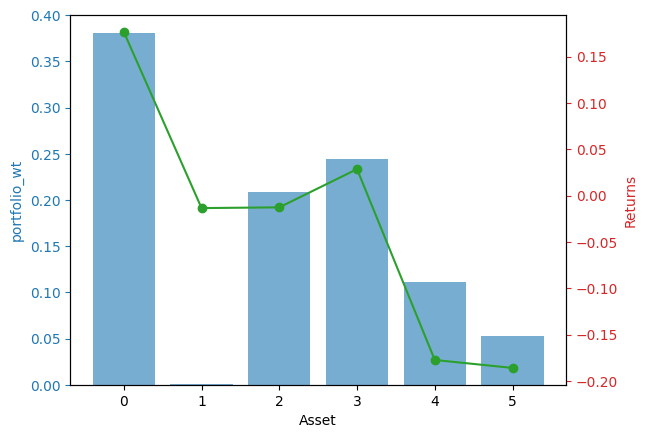

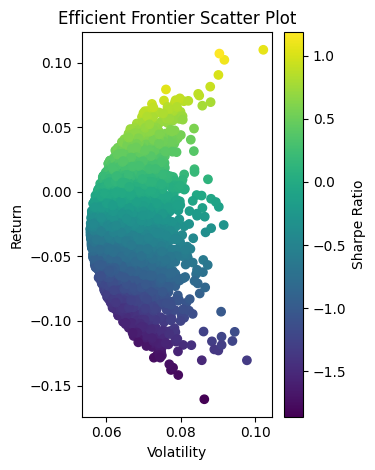

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 6))
plot, x_axis_1 = plt.subplots()

# Plot portfolio weights as a bar chart
x_axis_1.bar(range(num_assets), optimal_portfolio, align='center', alpha=0.6)
x_axis_1.set_xlabel('Asset')
x_axis_1.set_ylabel('portfolio_wt', color='tab:blue')
x_axis_1.tick_params('y', colors='tab:blue')

# Create a second y-axis for returns
x_axis_2 = x_axis_1.twinx()
x_axis_2.plot(range(num_assets), historic_returns, color='tab:green', marker='o')
x_axis_2.set_ylabel('Returns', color='tab:red')
x_axis_2.tick_params('y', colors='tab:red')
plt.show()

# Plot the efficient frontier scatter plot
plt.subplot(1, 2, 2)
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier Scatter Plot')

plt.tight_layout()
plt.show()

# Particle Swarm Optimization

In [ ]:
def data_preprocess():
    Data = ['HDB.csv', 'IBN.csv', 'WIT.csv', 'INFY.csv', 'CTSH.csv', 'ACN.csv']
    data_df = []

    for fl_indx in Data:
        temp = pd.read_csv(fl_indx)
        temp.columns = ['Date', fl_indx.replace('.csv', '')]
        data_df.append(temp)

    stock_list = reduce(lambda left, right: pd.merge(left, right, on='Date'), data_df)
    historic_returns = (stock_list.iloc[0, 1:] - stock_list.iloc[12, 1:]) / stock_list.iloc[12, 1:]
    return data_df,stock_list,historic_returns

In [ ]:
def calculate_portfolio_return(x, y):
    ans = np.sum(y * x)
    return ans

In [ ]:
def initialize_part(num_particles, num_assets):
    # Initialize particles and velocities more realistically
    particles = np.random.rand(num_particles, num_assets) * 0.5
    velocities = np.random.rand(num_particles, num_assets) * 0.1
    personal_best = particles.copy()
    return particles,velocities,personal_best

In [ ]:
def find_global_best(particles,historic_returns):
    best_fitness = float('-inf')  # Initialize with negative infinity
    global_best_position = None

    for part_pos in particles:
        current_fitness = calculate_portfolio_return(part_pos, historic_returns)
        if current_fitness > best_fitness:
            best_fitness = current_fitness
            global_best_position = part_pos.copy()
    return global_best_position

In [ ]:
def cal_velocity(indx,velocities,particles,personal_best,global_best):
    acceleration_coefficient=1.5
    vel_influence = 0.5
    rand1=np.random.rand()
    rand2=np.random.rand()
    velocities[indx] = (vel_influence * velocities[indx] +
            acceleration_coefficient * rand1 * (personal_best[indx] - particles[indx]) +
            acceleration_coefficient * rand2 * (global_best - particles[indx]))
    return velocities[indx]

In [ ]:
def cal_position(indx,particles,velocities):
    #updating positions of particles
    particles[indx] = particles[indx] + velocities[indx]
    particles[indx] = np.maximum(0, np.minimum(1, particles[indx]))
    particles[indx] = particles[indx]/np.sum(particles[indx])
    return particles[indx]

In [ ]:
def eval_best_return(indx,particles,historic_returns,personal_best,global_best):
    current_portfolio_return = calculate_portfolio_return(particles[indx],historic_returns)
    personal_best_return = calculate_portfolio_return(personal_best[indx], historic_returns)
    # Update personal best if needed
    if current_portfolio_return > personal_best_return:
        personal_best[indx] = particles[indx].copy()

    # Update global best if needed
    if current_portfolio_return > calculate_portfolio_return(global_best, historic_returns):
        global_best = particles[indx].copy()
    return personal_best,global_best

In [ ]:
def particle_swarm_algo(particles,personal_best,global_best):
    # Generate random historical returns for assets
    np.random.seed(100)
    num_particles = 50
    acceleration_coefficient=1.5
    vel_influence = 0.5
    #updating velocity and position for each iteration
    for indx in range(num_particles):
        rand1=np.random.rand()
        rand2=np.random.rand()
        #updating velocities
        velocities[indx] = cal_velocity(indx,velocities,particles,personal_best,global_best)
        #updating positions of particles
        particles[indx] = cal_position(indx,particles,velocities)
        personal_best,global_best=eval_best_return(indx,particles,historic_returns,personal_best,global_best)

In [ ]:
def find_optimal(global_best,historic_returns):
    optimal_portfolio = global_best
    print("Optimal Portfolio Weights:")
    print(optimal_portfolio)
    print("Expected Return (12 months):", np.sum(historic_returns * optimal_portfolio))
    return optimal_portfolio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

#data preprocess
data_df,stock_list,historic_returns=data_preprocess()

# Define parameters
num_assets = historic_returns.shape[0]
num_particles = 50
iterations = 100
vel_influence = 0.5
acceleration_coefficient=1.5

#initialize
particles,velocities,personal_best=initialize_part(num_particles,num_assets);
global_best = find_global_best(particles,historic_returns)
for it in range(iterations):
    particle_swarm_algo(particles,personal_best,global_best)
optimal_portfolio=find_optimal(global_best,historic_returns)

Optimal Portfolio Weights:
[0.35451161 0.12880969 0.23206529 0.01605829 0.05363998 0.0794118 ]
Expected Return (12 months): 0.034095201352412986


In [ ]:
# Efficient Frontier Calculation and Scatter Plot
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
risk_free_rate = 0.0

# Ensure historic_returns is treated as a 2D array
historic_returns_2d = historic_returns.to_numpy().reshape(-1, 1)

# Calculate the covariance matrix using rowvar=False
cov_matrix = np.cov(historic_returns_2d.astype(float), rowvar=False)

for i in range(num_portfolios):
    weights = np.random.rand(num_assets)
    weights /= np.sum(weights)

    portfolio_return = np.sum(historic_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = (portfolio_return - risk_free_rate) / portfolio_volatility

<Figure size 1200x600 with 0 Axes>

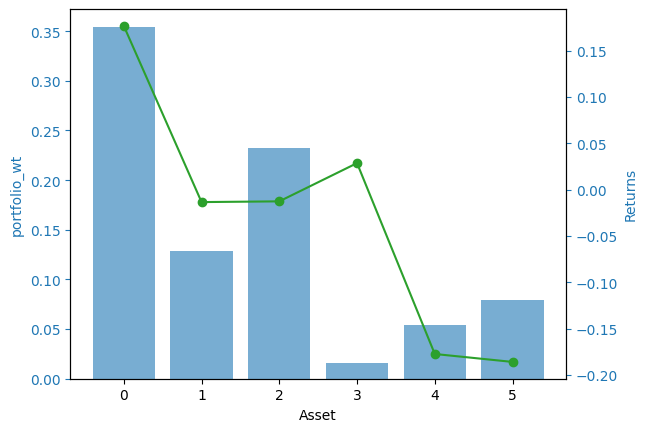

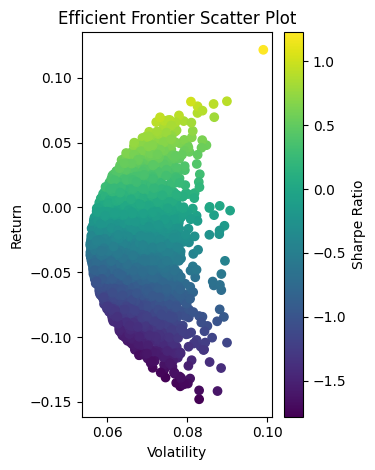

In [ ]:
# Plotting the results
#creating for 12 months and 6 company stocks
plt.figure(figsize=(12, 6))
plot, x_axis_1 = plt.subplots()

# Plot portfolio weights as a bar chart
x_axis_1.bar(range(num_assets), optimal_portfolio, align='center', alpha=0.6)
x_axis_1.set_xlabel('Asset')
x_axis_1.set_ylabel('portfolio_wt', color='tab:blue')
x_axis_1.tick_params('y', colors='tab:blue')

# Create a second y-axis for returns
x_axis_2 = x_axis_1.twinx()
x_axis_2.plot(range(num_assets), historic_returns, color='tab:green', marker='o')
x_axis_2.set_ylabel('Returns', color='tab:blue')
x_axis_2.tick_params('y', colors='tab:blue')
plt.show()

# Plot the efficient frontier scatter plot
plt.subplot(1, 2, 2)
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier Scatter Plot')

plt.tight_layout()
plt.show()

# GENETIC ALGORITHM

In [139]:
def data_preprocess():
    Data = ['HDB.csv', 'IBN.csv', 'WIT.csv', 'INFY.csv', 'CTSH.csv', 'ACN.csv']
    data_df = []

    for fl_indx in Data:
        temp = pd.read_csv(fl_indx)
        temp.columns = ['Date', fl_indx.replace('.csv', '')]
        data_df.append(temp)

    stock_list = reduce(lambda left, right: pd.merge(left, right, on='Date'), data_df)
    historic_returns = (stock_list.iloc[0, 1:] - stock_list.iloc[12, 1:]) / stock_list.iloc[12, 1:]
    return data_df,stock_list,historic_returns

In [ ]:
def calculate_portfolio_return(x, y):
    if np.any(x < 0):  # Check if any weights are negative
        return -np.inf
    ans = np.sum(y * x)
    return (-1)*ans

In [ ]:
def initialize_population(population_size,num_assets):
    population = np.random.rand(population_size, num_assets)
    population =population / np.sum(population, axis=1, keepdims=True)
    return population

In [ ]:
def create_new_population(num_assets,sorted_size,pref_population):
    mutation_rate = 0.1
    new_population = []
    for indx in range(population_size - sorted_size):
        pref_indices = np.random.choice(sorted_size, 2, replace=False)
        prefer1, prefer2 = pref_population[pref_indices[0]], pref_population[pref_indices[1]]

        #randomly generate crossover point from assets
        crossover_point = np.random.randint(num_assets)
        new_prefer = np.concatenate((prefer1[:crossover_point], prefer2[crossover_point:]))
        if np.random.rand() < mutation_rate:
            mutation_index = np.random.randint(num_assets)
            new_prefer[mutation_index] += np.random.randn() * 0.02
        new_prefer = new_prefer / np.sum(new_prefer)
        new_population.append(new_prefer)
    return new_population

In [ ]:
def genetic_algo(population,historic_returns):
    num_generations = 100
    population_size = 100
    mutation_rate = 0.1
    for iter in range(num_generations):
        performance = np.array([calculate_portfolio_return(ind, historic_returns) for ind in population])
        sorted_size = int(population_size * 0.4)
        pref_population = population[np.argsort(performance)[:sorted_size]]
        # Create a new generation through crossover and mutation
        new_population = create_new_population(num_assets,sorted_size,pref_population)
        # Combine pref population and the new population
        population = np.vstack((pref_population, new_population))
    return population

In [ ]:
def final_performance(population,historic_returns):
    final_performance_scores = np.apply_along_axis(lambda ind: calculate_portfolio_return(ind, historic_returns), axis=1, arr=population)
    best_portfolio = population[np.argmax(final_performance_scores)]
    return final_performance_scores

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

num_assets = historic_returns.shape[0]
num_generations = 100
population_size =  100
mutation_rate = 0.1

np.random.seed(12)
data_df,stock_list,historic_returns=data_preprocess()
population = initialize_population(population_size,num_assets)
population = genetic_algo(population,historic_returns)

final_performance_scores = final_performance(population,historic_returns)
optimal_portfolio = population[np.argmax(final_performance_scores)]

In [ ]:
# Efficient Frontier Calculation and Scatter Plot
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
risk_free_rate = 0.0

# Ensure historic_returns is treated as a 2D array
historic_returns_2d = historic_returns.to_numpy().reshape(-1, 1)

# Calculate the covariance matrix using rowvar=False
cov_matrix = np.cov(historic_returns_2d.astype(float), rowvar=False)

for i in range(num_portfolios):
    weights = np.random.rand(num_assets)
    weights /= np.sum(weights)

    portfolio_return = np.sum(historic_returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = (portfolio_return - risk_free_rate) / portfolio_volatility

<Figure size 1200x600 with 0 Axes>

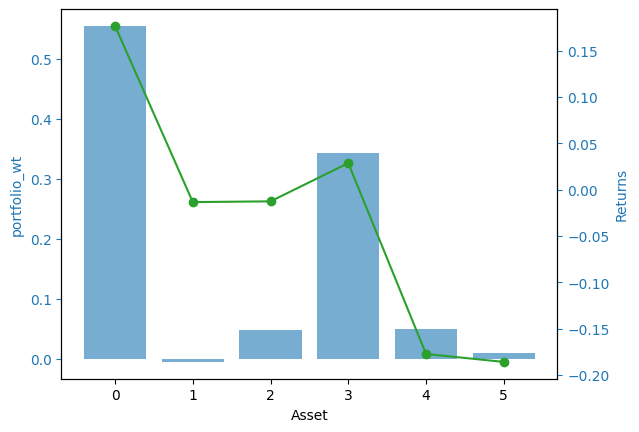

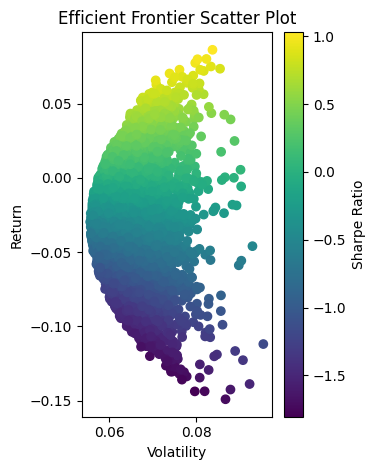

In [ ]:
# Plotting the results
#creating for 12 months and 6 company stocks
plt.figure(figsize=(12, 6))
plot, x_axis_1 = plt.subplots()

# Plot portfolio weights as a bar chart
x_axis_1.bar(range(num_assets), optimal_portfolio, align='center', alpha=0.6)
x_axis_1.set_xlabel('Asset')
x_axis_1.set_ylabel('portfolio_wt', color='tab:blue')
x_axis_1.tick_params('y', colors='tab:blue')

# Create a second y-axis for returns
x_axis_2 = x_axis_1.twinx()
x_axis_2.plot(range(num_assets), historic_returns, color='tab:green', marker='o')
x_axis_2.set_ylabel('Returns', color='tab:blue')
x_axis_2.tick_params('y', colors='tab:blue')
plt.show()

# Plot the efficient frontier scatter plot
plt.subplot(1, 2, 2)
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier Scatter Plot')

plt.tight_layout()
plt.show()

# SIMULATED ANNEALING

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [148]:
def calculate_portfolio_performance(weights, mean_returns, cov_matrix):
    portfolio_return = np.sum(weights * mean_returns) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return portfolio_return, portfolio_volatility

In [149]:
def simulated_annealing_optimization(mean_returns, cov_matrix, num_iterations=10000, initial_temperature=1.0, cooling_rate=0.95):
    num_assets = len(mean_returns)
    best_weights = np.random.rand(num_assets)
    current_weights = best_weights
    best_return, best_volatility = calculate_portfolio_performance(best_weights, mean_returns, cov_matrix)

    for i in range(num_iterations):
        temperature = initial_temperature * (cooling_rate ** i)
        new_weights = current_weights + np.random.normal(0, 0.1, num_assets)
        new_weights = new_weights / np.sum(new_weights)
        new_return, new_volatility = calculate_portfolio_performance(new_weights, mean_returns, cov_matrix)
        # Metropolis criterion
        if new_return > best_return or np.random.rand() < np.exp((new_return - best_return) / temperature):
            best_return = new_return
            best_volatility = new_volatility
            best_weights = new_weights
            current_weights = new_weights
    return best_weights, best_return, best_volatility

In [150]:
def data_preprocess():
    Data = ['HDB.csv', 'IBN.csv', 'WIT.csv', 'INFY.csv', 'CTSH.csv', 'ACN.csv']
    data_df = []

    for fl_indx in Data:
        temp = pd.read_csv(fl_indx)
        temp.columns = ['Date', fl_indx.replace('.csv', '')]
        data_df.append(temp)

    stock_list = reduce(lambda left, right: pd.merge(left, right, on='Date'), data_df)
    historic_returns = (stock_list.iloc[0, 1:] - stock_list.iloc[12, 1:]) / stock_list.iloc[12, 1:]
    # Extracting the closing prices for each asset
    close_prices = stock_list.iloc[:, 1:]
    # Calculate monthly returns
    monthly_returns = close_prices.pct_change().dropna()

    # Calculate mean returns
    mean_returns = monthly_returns.mean()
    return data_df, stock_list, historic_returns,mean_returns


In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_df, stock_list, historic_returns,mean_returns= data_preprocess()
num_assets = len(data_df)
historic_returns_2d = historic_returns.to_numpy().reshape(-1, 1)
cov_matrix = np.cov(historic_returns_2d.astype(float), rowvar=False)
optimal_weights, optimal_return, optimal_volatility = simulated_annealing_optimization(mean_returns, cov_matrix)

Simulated Annealing Optimization Results:
Optimal Weights: [0.98482688 0.97255662 0.49336293 0.3956484  0.85729738 0.47154014]
Optimal Return: 3.67939252883179
Optimal Volatility: 3.912477629908551


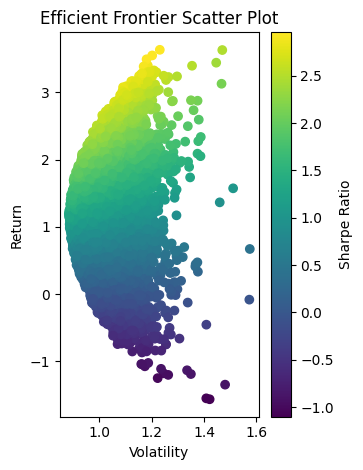

In [154]:
#plotting the data
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
risk_free_rate = 0.0
# Print results
print("Simulated Annealing Optimization Results:")
print("Optimal Weights:", optimal_weights)
print("Optimal Return:", optimal_return)
print("Optimal Volatility:",optimal_volatility)

# Plot the efficient frontier
portfolios = pd.DataFrame(columns=['Return', 'Volatility'])

for t in range(num_portfolios):
    weights = np.random.rand(num_assets)
    weights = weights / np.sum(weights)
    portfolio_return, portfolio_volatility = calculate_portfolio_performance(weights, mean_returns, cov_matrix)
    portfolios = pd.concat([portfolios, pd.DataFrame({'Return': [portfolio_return], 'Volatility': [portfolio_volatility]})], ignore_index=True)

    results[0, t] = portfolio_return
    results[1, t] = portfolio_volatility
    results[2, t] = (portfolio_return - risk_free_rate) / portfolio_volatility

# Plot the efficient frontier scatter plot
plt.subplot(1, 2, 2)
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier Scatter Plot')
plt.tight_layout()
plt.show()